In [1]:
import sys
import seaborn as sns
import os
import glob
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import avalanches as crfn
import admin_functions as adfn
import plot as pltfn
import scipy
from scipy import stats 
import IS as isfn
import network as netfn

sns.reset_orig()
#plt.style.use('dark_background')
%load_ext autoreload
%autoreload

# Define paths
#---------------------------------------------------------------------------
Fdrop = '/Users/dominicburrows/Dropbox/PhD/analysis/'
Fmac = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/'
Ffig = '/Users/dominicburrows/Dropbox/PhD/figures/'
Ftm = '/Volumes/Dominic Time Machine/'
experiment = 'PTZ-WILDTYPE'
savepath = Fdrop + 'Project/' + experiment + os.sep 

sys.version

'3.8.3 (default, Jul  2 2020, 11:26:31) \n[Clang 10.0.0 ]'

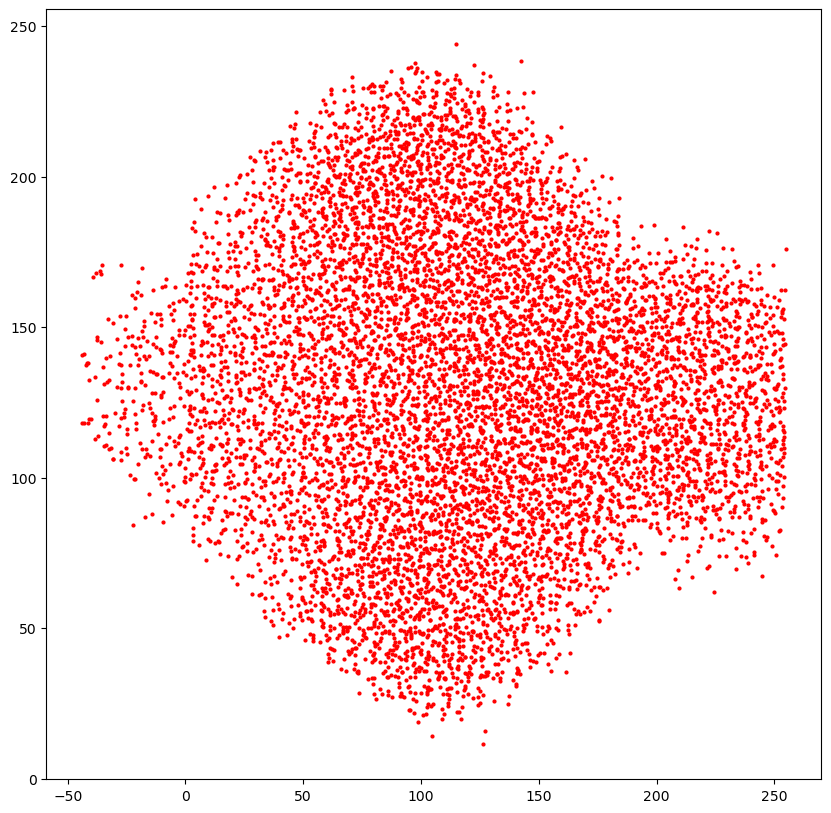

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     

# Node coordinates
#---------------------------------------------------------------------------
os.chdir(Fdrop + 'Project/' + experiment)
node = sorted(glob.glob('knodes*'))
fig,axarr = plt.subplots(figsize = (10,10))
nodes = np.load(node[0])
axarr.scatter(nodes[:,0], nodes[:,1], s = 4, color = 'red' , alpha = 1)
plt.show()

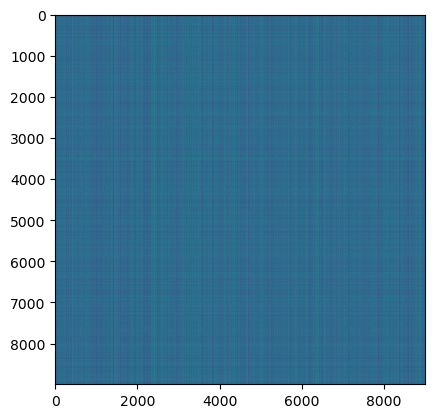

In [4]:
# K LIN + P LIN SCALE 
import numpy as np
import matplotlib.pyplot as plt
p_vals = np.array(np.append(0.001, np.linspace(0.1, 1, 11))).tolist()
k_vals = np.array(np.append(1/nodes.shape[0], [i/nodes.shape[0] for i in np.linspace(20, 200, 11)])).tolist()
cell_locs = nodes
dist = euclidean_distances(nodes)
plt.imshow(dist)
plt.show()

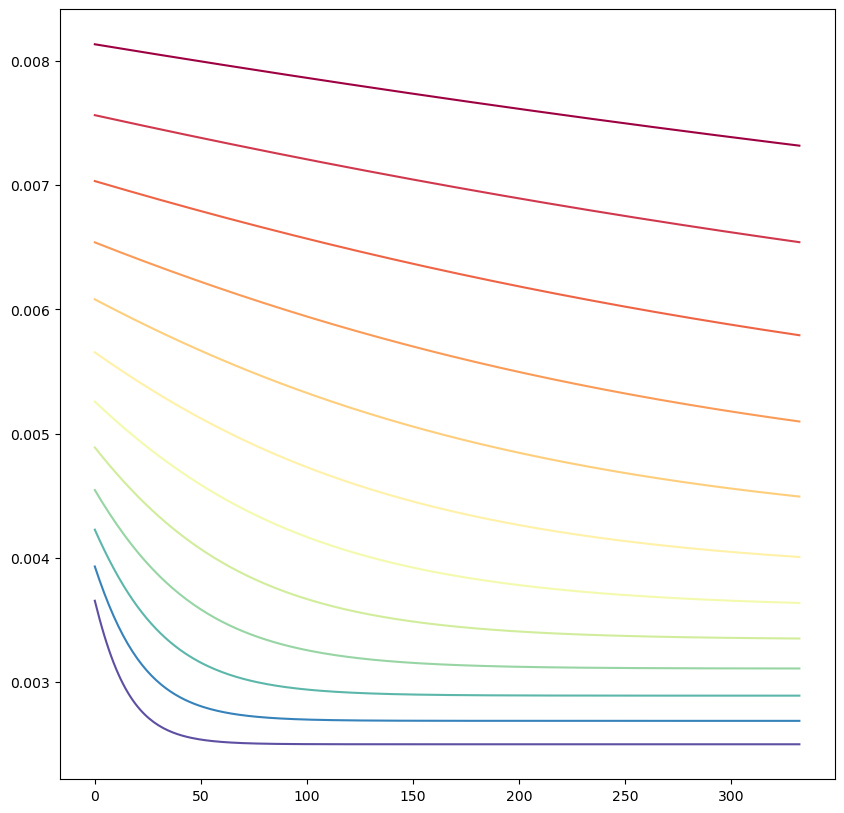

In [5]:
# Simple sigmoid function to 'soften' the exponential
#-------------------------------------------------------------------------------
def sig(x):
  return 1 / (1+np.exp(-x))

# Conversion from distance to edge weights, scaled (itself exponentially) by s
#-------------------------------------------------------------------------------
def dist2edge(distance, divisor, s):
  edgeweights = np.exp(s/5)*sig(np.exp(-soften/np.exp(s)*distance))/divisor
  return edgeweights

#S parameters
Nsteps  = 12
divisor = 200
soften = 0.07
s_vals   = np.array(np.linspace(0, 4, Nsteps)).tolist()

#Plot each s value
fig, ax = plt.subplots(1, figsize=(10,10))
colors  = cm.Spectral_r(np.linspace(0,1,Nsteps))
distance = np.linspace(0, np.max(dist), 300)
for s in range(len(s_vals)):
  ax.plot(distance, dist2edge(distance, divisor, s_vals[s]), c=colors[s])
plt.show()


In [6]:
# Choose path and create lists of coord and trace files
#---------------------------------------------------------------------------
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
blnlist = sorted(glob.glob('*BLN*_av.npy*'))
p20list = sorted(glob.glob('*PTZ20*_av.npy*'))

In [7]:
choose = 0
bln_distlist = [np.load(blnlist[i])[choose] for i in range(len(blnlist))]
p20_distlist = [np.load(p20list[i])[choose] for i in range(len(p20list))]
bln_vec = []
p20_vec = []
for i in range(len(bln_distlist)):
    bln_vec = np.append(bln_vec, bln_distlist[i])
    p20_vec = np.append(p20_vec, p20_distlist[i])

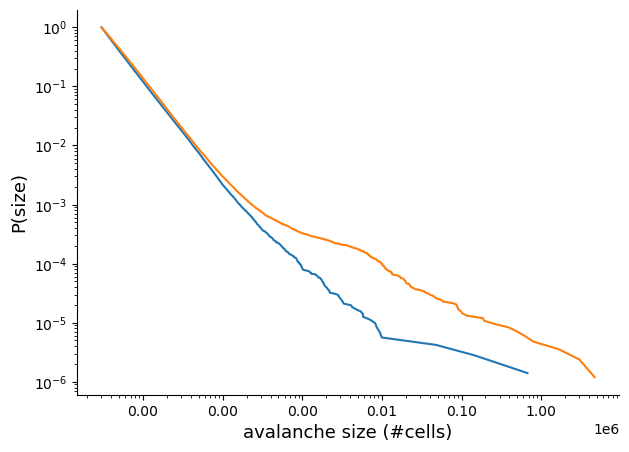

In [8]:
import matplotlib
import powerlaw
fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
avdistcut = bln_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1)
avdistcut = p20_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1)

axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

In [9]:
#Calculate number of simulatons to do - to have 95% chance of generating maximum avalanche
def num_sims(empirical, cutoff):
    import matplotlib.pyplot as plt
    import math
    fig, axarr = plt.subplots(figsize = (7,5))
    hist = axarr.hist(empirical, bins = 100000, density = True, histtype = 'step', cumulative = -1)
    p = 1-(10**(np.log10(hist[0])[np.where(np.log10(hist[1]) > np.log10(cutoff))[0][0]])) #probability of getting avalanches of size cutoff or smaller
    number = 0.05 
    base = p
    exponent = int(math.log(number, base)) #number of simulations as the power to which p is raised to get 95% probability 
    return(exponent)

#Simulation parameters
#======================
cutoff = 1000
n_sims= num_sims(bln_vec, cutoff)
n_sims

36781

In [28]:
#Check paramaters
s0 = s_vals[2]
k0 = k_vals[10]
p0 = p_vals[0]

print('divisor = ' + str(divisor))
print('soften = ' + str(soften))
print('cutoff = ' + str(cutoff))
print('n_sims = ' + str(n_sims))
print('s0 = ' + str(s0))
print('k0 = ' + str(k0 *nodes.shape[0]))
print('p0 = ' + str(p0))

divisor = 200
soften = 0.07
cutoff = 1000
n_sims = 36781
s0 = 0.7272727272727273
k0 = 182.0
p0 = 0.001


In [ ]:
#Check gradient descent works - start - sweep min, fit - bln_vec
os.chdir(F10t + 'Project/' + experiment)

from scipy.optimize import minimize
from scipy import stats
total_list = []
def ks_dist(params):
    print(params)  # <-- you'll see that params is a NumPy array
    s, k, p  = params # <-- for readability you may wish to assign names to the component variables
    avs = netfn.netsim(dist).simulate(s, k, p, 10, divisor, soften, cutoff, n_sims, 'directed').av_size
    ks = stats.ks_2samp(empirical, avs)[0]
    total_list.append([params, ks, avs])
    print('ks = ' + str(ks))
    return ks

#Define params
empirical = bln_vec
dist = dist
initial_guess = [s0, k0, p0]
bnds = ( (0,10), (5/nodes.shape[0], 300/nodes.shape[0]),  (0,1) )
result = minimize(ks_dist, initial_guess, bounds = bnds, method = 'BFGS')

/Users/dominicburrows/anaconda3/envs/python38/lib/python3.8/site-packages/scipy/optimize/_minimize.py:533: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


[0.72727273 0.02024472 0.001     ]
ks = 0.22076891935910753
[0.72727274 0.02024472 0.001     ]
ks = 0.21811326209599058
[0.72727273 0.02024473 0.001     ]
ks = 0.22641727857082194
[0.72727273 0.02024472 0.00100001]
ks = 0.21590593913971295
[ 1.06626414 -0.70076146  0.6217535 ]
ks = 0.999918556826974
[ 1.06626416 -0.70076146  0.6217535 ]
ks = 0.999918556826974
[ 1.06626414 -0.70076148  0.6217535 ]
ks = 0.999918556826974
[ 1.06626414 -0.70076146  0.62175352]
ks = 0.999918556826974
[ 0.84026954 -0.22008998  0.20791723]


In [27]:
result

      fun: 0.10488143413592943
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-187286.1981845 , -828442.12232422, -229271.19598743])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 136
      nit: 3
     njev: 34
   status: 0
  success: True
        x: array([7.65135306e-06, 1.82448715e-02, 1.00539703e-03])

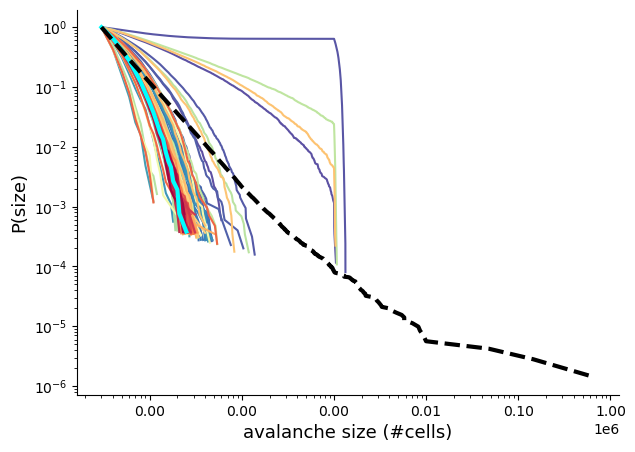

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy
os.chdir(F10t + 'Project/' + experiment)


colors = cm.Spectral_r(np.linspace(0, 1, len(total_list)))

#Cycle length - small network
import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   
# Node coordinates
#---------------------------------------------------------------------------
for i in range(len(total_list)):
    av_dense = total_list[i][2]
    powerlaw.plot_ccdf(av_dense, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
    

avdistcut = total_list[-1][2]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'cyan')

avdistcut = bln_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

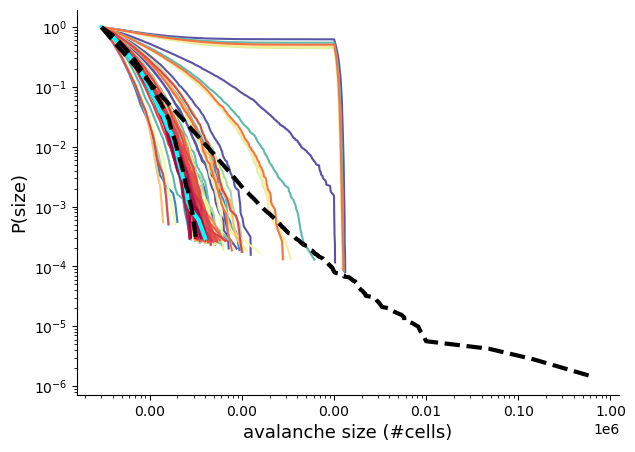

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy
os.chdir(F10t + 'Project/' + experiment)


colors = cm.Spectral_r(np.linspace(0, 1, len(total_list)))

#Cycle length - small network
import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   
# Node coordinates
#---------------------------------------------------------------------------
for i in range(len(total_list)):
    av_dense = total_list[i][2]
    powerlaw.plot_ccdf(av_dense, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
    

avdistcut = total_list[-1][2]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'cyan')
avdistcut = tofit_d
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')

avdistcut = bln_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

In [15]:
result

      fun: 0.06992271095120961
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([390863.76269856, 299052.74857679, 496130.49820543])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 108
      nit: 3
     njev: 27
   status: 0
  success: True
        x: array([5.21867206e-07, 1.82424823e-02, 1.00052119e-03])

In [16]:
check = netfn.netsim(dist).simulate(result['x'][0], result['x'][1], result['x'][2], 10, divisor, soften, cutoff, n_sims, 'directed').av_size

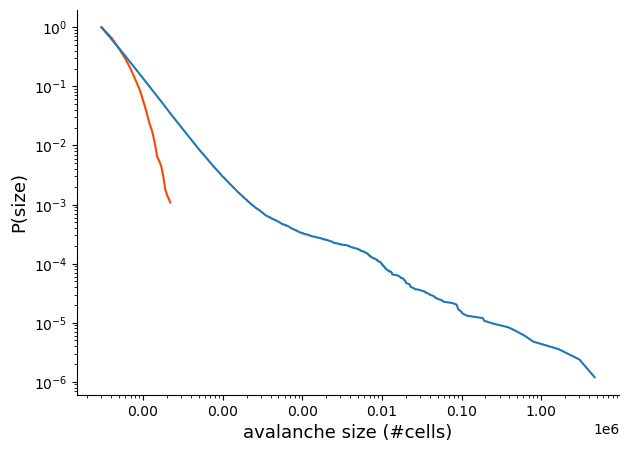

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy

colors = cm.cool(np.linspace(0, 1, len(node)))

#Cycle length - small network
import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   
# Node coordinates
#---------------------------------------------------------------------------
os.chdir(F10t + 'Project/' + experiment)
powerlaw.plot_ccdf(check, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = 'orangered')

avdistcut = p20_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1)
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

In [19]:
result['x'][1]* nodes.shape[0]

163.99991575993621

In [21]:
result['x'][2]

0.0010005211927279225